In [10]:
from datasets import load_dataset 

ds = load_dataset("lmsys/mt_bench_human_judgments")
human_split = ds["human"]
gpt4_split = ds["gpt4_pair"]

In [7]:
print(human_split.column_names)

['question_id', 'model_a', 'model_b', 'winner', 'judge', 'conversation_a', 'conversation_b', 'turn']


## Recreate agreement calculations

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict


def canonical_judge(judge):
    if isinstance(judge, list) and judge and judge[0] == "gpt-4":
        return "gpt4-pair"
    if isinstance(judge, str) and judge.startswith(("expert", "author")):
        return "human"
    return judge

def fold_tie(v):
    return "tie" if "tie" in v else v

def build_vote_bag(rows):
    """Build a bag of votes from the rows of the dataset."""
    bag = [defaultdict(dict), defaultdict(dict)]

    for row in rows:
        turn = row["turn"] - 1 # change from 1-indexed to 0-indexed

        if row["model_a"] < row["model_b"]:
            key = (row["question_id"], row["model_a"], row["model_b"])
            label = row["winner"]

        else:
            key = (row["question_id"], row["model_b"], row["model_a"])
            label = {"model_a" : "model_b", "model_b" : "model_a"}.get(row["winner"], row["winner"])

        judge = canonical_judge(row["judge"])

        bag[turn].setdefault(key, {}).setdefault(judge, []).append(label)

    return bag


def agree_turn(bag_turn, judgeA="gemini", judgeB="human", drop_ties=True):
    """
    Return (agree, total) for one turn.
    Mirrors MT-Bench reference exactly.
    """
    agree = tot = 0
    for votes in bag_turn.values():
        if judgeA not in votes or judgeB not in votes:
            continue                                # need both judges
        vA = fold_tie(votes[judgeA][0])             # LLM gives 1 vote
        if drop_ties and vA == "tie":
            continue
        for vB in votes[judgeB]:                    # humans may vote many times
            vB = fold_tie(vB)
            if drop_ties and vB == "tie":
                continue
            tot   += 1
            agree += (vA == vB)                     # bool adds as 1/0
    return agree, tot


In [50]:
bag = build_vote_bag(list(human_split) + list(gpt4_split))

for turn in [0, 1]:
    for tie in [False, True]:
        agree, total = agree_turn(bag[turn], "gpt4_pair", "human", drop_ties=tie)
        print(f"Agreement (Tie: {not tie}, turn-{turn+1}): {agree}/{total} = {agree/total:.2%}")

Agreement (Tie: True, turn-1): 1125/1689 = 66.61%
Agreement (Tie: False, turn-1): 911/1060 = 85.94%
Agreement (Tie: True, turn-2): 1095/1666 = 65.73%
Agreement (Tie: False, turn-2): 912/1069 = 85.31%


In [52]:
from scipy.stats import bootstrap

def prop_agree(bag_turn, jA, jB, n=10_000):
    agree, total = agree_turn(bag_turn, jA, jB, drop_ties=True)
    hits = np.concatenate([np.ones(agree), np.zeros(total-agree)])  
    ci = bootstrap((hits,), lambda x: x.mean(), n_resamples=n, method='basic', confidence_level=0.95).confidence_interval
    return hits.mean(), ci.low, ci.high

agree, ci_low, ci_high = prop_agree(bag[0], "gpt4_pair", "human")
print(f"Proportion agreement (turn-1): {agree:.2%} ({ci_low:.2%}, {ci_high:.2%})")

Proportion agreement (turn-1): 85.94% (83.87%, 88.02%)


agree        0    1
category           
coding      31  174
extraction  21  235
humanities  49  282
math         9  181
reasoning   19  161
roleplay    65  279
stem        37  298
writing     75  213

χ² = 65.12   p-value = 1.42e-11


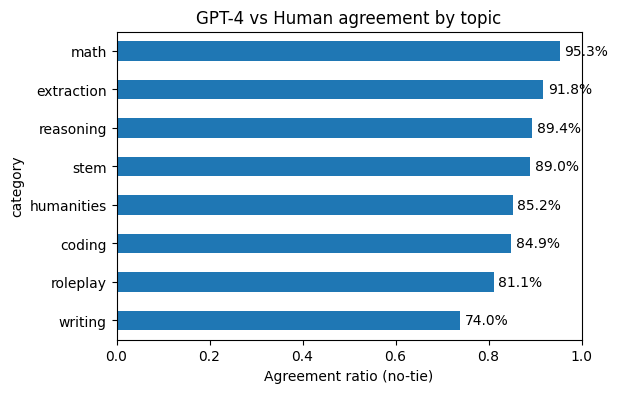

In [ ]:
from datasets import load_dataset
import pandas as pd
from scipy.stats import chi2_contingency

# load the metadata for categories
meta = load_dataset("HuggingFaceH4/mt_bench_prompts", split="train")
id2cat = [row["category"] for row in meta]        # index 0 … 79

def category_of(qid: int) -> str:
    """Turn both first- and second-turn IDs (0-159) into a topic label."""
    return id2cat[qid % 80]


# collect agreement rates for each topic to construct contingency table
records = []
for turn_idx in (0, 1):                          
    for (qid, *_), votes in bag[turn_idx].items():
        if "gpt4_pair" not in votes or "human" not in votes:
            continue
        g_vote = fold_tie(votes["gpt4_pair"][0])          
        for h_vote in votes["human"]:
            h_vote = fold_tie(h_vote)
            if "tie" in (g_vote, h_vote):   # drop ties              
                continue
            records.append({
                "category": category_of(qid),
                "agree":    int(fold_tie(g_vote) == fold_tie(h_vote))
            })

df = pd.DataFrame(records)

# create a contingency table for the chi-squared test
tbl = pd.crosstab(df["category"], df["agree"])         
chi2, p, *_ = chi2_contingency(tbl.values)
print(tbl)                                                
print(f"\nχ² = {chi2:.2f}   p-value = {p:.3g}")

# plot  agreement ratios by topic
agreement_ratios = (tbl[1] / tbl.sum(1)).sort_values()  # 1 == agree
ax = agreement_ratios.plot.barh(figsize=(6,4), title="GPT-4 vs Human agreement by topic")
ax.set_xlabel("Agreement ratio (no-tie)")
ax.set_xlim(0,1)
for y, v in enumerate(agreement_ratios):
    ax.text(v + 0.01, y, f"{v*100:.1f}%", va="center")
